In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("CreditCardSystem").getOrCreate()

In [3]:
branch_df = spark.read.json("cdw_sapp_branch.json")
creditcard_df = spark.read.json("cdw_sapp_credit.json")
customer_df = spark.read.json("cdw_sapp_custmer.json")

In [4]:
branch_df.show()
creditcard_df.show()
customer_df.show()

+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|      BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|       Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|  Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|      Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|  1234663064|          FL|   Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|  1234849701|          PA|        14th Street|     19406|2018-04-18T16:51:...|
|         Paters

In [5]:
from pyspark.sql.functions import initcap, lower, concat_ws, regexp_replace


In [6]:
customer_df = customer_df.withColumn("FIRST_NAME", initcap(customer_df["FIRST_NAME"]))
customer_df = customer_df.withColumn("MIDDLE_NAME", lower(customer_df["MIDDLE_NAME"]))
customer_df = customer_df.withColumn("LAST_NAME", initcap(customer_df["LAST_NAME"]))
customer_df = customer_df.withColumn("FULL_STREET_ADDRESS", concat_ws(", ", customer_df["STREET_NAME"], customer_df["APT_NO"]))


In [7]:
customer_df.show()

+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|Main Street North...|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    brendan|123453023|

In [8]:
from pyspark.sql import functions as F

customer_df = customer_df.withColumn(
    "CUST_PHONE",
    F.when(
        F.length(customer_df["CUST_PHONE"]) == 7,
        F.concat(F.lit("555"), customer_df["CUST_PHONE"])
    ).otherwise(customer_df["CUST_PHONE"])
)

In [9]:
customer_df.show()

+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|5551237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|Main Street North...|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|5551238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    brendan|123453023|

In [10]:
customer_df = customer_df.withColumn("CUST_PHONE",
                                      F.concat(F.lit("("),
                                               F.substring("CUST_PHONE", 1, 3),
                                               F.lit(")"),
                                               F.substring("CUST_PHONE", 4, 3),
                                               F.lit("-"),
                                               F.substring("CUST_PHONE", 7, 4)))


In [11]:
customer_df.show()

+------+----------------+------------+-------------+--------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+--------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|(555)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|Main Street North...|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|(555)123-8933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    bre

In [12]:
branch_df.createOrReplaceTempView("branch")
creditcard_df.createOrReplaceTempView("creditcard")
customer_df.createOrReplaceTempView("customer")

In [13]:
result = spark.sql("""
    SELECT * 
    FROM customer c
    JOIN creditcard cc ON c.SSN = cc.CUST_SSN
    JOIN branch b ON cc.BRANCH_CODE = b.BRANCH_CODE
""")


In [14]:
result.show()

+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+------------+-------------------+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+-----------------+-----------+------------+------------+------------+---------------+----------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN| STREET_NAME|FULL_STREET_ADDRESS|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|  BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+--

In [ ]:
result_left = spark.sql("""
    SELECT *
    FROM customer c
    LEFT JOIN creditcard cc ON c.SSN = cc.CUST_SSN
    LEFT JOIN branch b ON cc.BRANCH_CODE = b.BRANCH_CODE
    WHERE cc.CUST_SSN IS NULL OR b.BRANCH_CODE IS NULL
""")

In [ ]:
result_right = customer_df.join(creditcard_df, customer_df.SSN == creditcard_df.CUST_SSN, "right") \
                    .join(branch_df, creditcard_df.BRANCH_CODE == branch_df.BRANCH_CODE, "right")

result_right.show()

In [ ]:
result_outer = customer_df.join(creditcard_df, customer_df.SSN == creditcard_df.CUST_SSN, "outer") \
                    .join(branch_df, creditcard_df.BRANCH_CODE == branch_df.BRANCH_CODE, "outer")

result_outer.show()

In [ ]:
# sparksql = SparkSession.builder \
#                                 .appName("CreditCardSystem") \
#                                 .config("spark.jars", )
#                                 .getOrCreate()

# sparksql = SparkSession.builder \
#            .appName('SparkByExamples.com') \
#            .config("spark.jars", "mysql-connector-java-8.0.13.jar")
#            .getOrCreate()

In [20]:
# jdbc_url = "jdbc:mysql://localhost:3306/creditcard_capstone"
# table_prefix = "CDW_SAPP_"
# db_properties = {
#     "user": "root",
#     "password": "password",
#     "driver": "com.mysql.cj.jdbc.Driver"
# }

# df=spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
#                                      user="root",\
#                                      password="password",\
#                                      url="jdbc:mysql://localhost:3306/creditcard_capstone",\
#                                      dbtable="").load()
# df.show()

import mysql.connector

conn = mysql.connector.connect(user='root', 
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)
cursor = conn.cursor()

In [21]:
cursor.execute("drop table if exists creditcard;")
cursor.execute("drop table if exists customer;")
cursor.execute("drop table if exists branch;")

In [22]:
# Write to MySQL Table
branch_df.write \
  .format("jdbc") \
  .option("driver","com.mysql.cj.jdbc.Driver") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "branch") \
  .option("user", "root") \
  .option("password", "password") \
  .save()



In [23]:
customer_df.write \
  .format("jdbc") \
  .option("driver","com.mysql.cj.jdbc.Driver") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "customer") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [24]:
creditcard_df.write \
  .format("jdbc") \
  .option("driver","com.mysql.cj.jdbc.Driver") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [97]:
conn.close()

In [ ]:
# import pandas as pd

# branch_df.toPandas().to_sql("branch", conn, index=False)

# branch_df.createOrReplaceTempView("branch")
# creditcard_df.createOrReplaceTempView("creditcard")
# customer_df.createOrReplaceTempView("customer")

In [ ]:
# query = "create table test1(field1 int, field2 varchar(10));"
# cursor.execute(query)

In [ ]:
# cursor.execute("drop table test1")

In [ ]:
# query = "create table ;"
# cursor.execute(query)

In [ ]:
# branch_df.write.jdbc(jdbc_url, table=f"{table_prefix}BRANCH", mode="overwrite", properties=db_properties)
# creditcard_df.write.jdbc(jdbc_url, table=f"{table_prefix}CREDIT_CARD", mode="overwrite", properties=db_properties)
# customer_df.write.jdbc(jdbc_url, table=f"{table_prefix}CUSTOMER", mode="overwrite", properties=db_properties)


********************************
*2.1 Transaction Details Module*
********************************

In [25]:
import mysql.connector

def zip_transactions(zip_code, month, year):

    conn = mysql.connector.connect(user='root', 
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the transactions made by customers in a given zip code for a given month and year
    query = """
    SELECT *
    FROM customer c
    LEFT JOIN creditcard cc ON c.SSN = cc.CUST_SSN
    LEFT JOIN branch b ON cc.BRANCH_CODE = b.BRANCH_CODE
    WHERE c.CUST_ZIP = %s AND cc.MONTH = %s AND cc.YEAR = %s
    ORDER BY cc.DAY DESC
    """

    # Execute the query with the provided parameters
    cursor.execute(query, (zip_code, month, year))

    # Fetch all the results
    results = cursor.fetchall()

    # Display the transactions
    print("Transactions by Zip Code and Dates:")
    for row in results:
        print(row)

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [26]:
def type_transactions(transaction_type):
    # Establish a connection to the MySQL database

    conn = mysql.connector.connect(user='root', 
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the number and total values of transactions for a given type
    query = """
    SELECT COUNT(*) AS transaction_count, SUM(Transaction_Value) AS total_value
    FROM creditcard
    WHERE TRANSACTION_TYPE = %s
    """

    # Execute the query with the provided parameter
    cursor.execute(query, (transaction_type,))

    # Fetch the result
    result = cursor.fetchone()

    # Display the transaction details
    print("Transaction Type:", transaction_type)
    print("Transaction Count:", result[0])
    print("Total Value:", result[1])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [27]:
def state_transactions(state):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the total number and total values of transactions for branches in a given state
    query = """
    SELECT COUNT(*) AS transaction_count, SUM(Transaction_Value) AS total_value
    FROM creditcard
    JOIN branch ON creditcard.BRANCH_CODE = branch.BRANCH_CODE
    WHERE branch.BRANCH_STATE = %s
    """

    # Execute the query with the provided parameter
    cursor.execute(query, (state,))

    # Fetch the result
    result = cursor.fetchone()

    # Display the transaction details
    print("State:", state)
    print("Transaction Count:", result[0])
    print("Total Value:", result[1])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [91]:
# Main program
def main_one():
    while True:
        print("Transaction Details Module")
        print("1) Display transactions by zip code for a given month and year")
        print("2) Display number and total values of transactions for a given type")
        print("3) Display total number and total values of transactions for branches in a given state")
        print("4) Exit")

        choice = input("Enter your choice (1-4): ")

        if choice == "1":
            zip_code = input("Enter the zip code(Ex:12345): ")
            month = input("Enter the month(For January, enter 1): ")
            year = input("Enter the year(Ex:2018): ")
            zip_transactions(zip_code, month, year)
        elif choice == "2":
            transaction_type = input("Enter the transaction type(Ex:Gas): ")
            type_transactions(transaction_type)
        elif choice == "3":
            state = input("Enter the state(Ex:NY): ")
            state_transactions(state)
        elif choice == "4":
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main_one() 

Transaction Details Module
1) Display transactions by zip code for a given month and year
2) Display number and total values of transactions for a given type
3) Display total number and total values of transactions for branches in a given state
4) Exit
Invalid choice. Please try again.
Transaction Details Module
1) Display transactions by zip code for a given month and year
2) Display number and total values of transactions for a given type
3) Display total number and total values of transactions for branches in a given state
4) Exit
Transactions by Zip Code and Dates:
('109', '4210653396189363', 'Natchez', 'United States', 'BWare@example.com', '(555)124-2316', 'MS', '39120', 'Blair', 'Ware', '2018-04-21T12:49:02.000-04:00', 'antone', 123457139, 'Linden Street', 'Linden Street, 109', 7, '4210653396189363', 123457139, 27, 2, 15254, 'Healthcare', 98.94, 2018, 'Paterson', 7, 'Example Bank', '1234144890', 'NJ', 'Jefferson Street', 7501, '2018-04-18T16:51:47.000-04:00')
('109', '42106533961

*****************************
*2.2 Customer Details Module*
*****************************

In [34]:
import mysql.connector

def display_account(customer_ssn):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the account details of a customer
    query = """
    SELECT *
    FROM customer
    WHERE SSN = %s
    """

    # Execute the query with the provided parameter
    cursor.execute(query, (customer_ssn,))

    # Fetch the result
    result = cursor.fetchone()

    # Display the account details
    print("Account Details:")
    print("SSN:", result[12])
    print("First Name:", result[8])
    print("Middle Name:", result[11])
    print("Last Name:", result[9])
    print("Street Name:", result[13])
    print("City:", result[2])
    print("State:", result[6])
    print("Zip Code:", result[7])
    print("Country:", result[3])
    print("Phone:", result[5])
    print("Email:", result[4])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [93]:
def modify_account(customer_ssn):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()
    
    column_name_dict = {0:'APT_NO',       1:'CREDIT_CARD_NO', 
                        2:'CUST_CITY',    3:'CUST_COUNTRY',
                        4:'CUST_EMAIL',   5:'CUST_PHONE',
                        6:'CUST_STATE',   7:'CUST_ZIP',
                        8:'FIRST_NAME',   9:'LAST_NAME',
                        10:'LAST_UPDATED',11:'MIDDLE_NAME',
                        12:'SSN',         13:'STREET_NAME',
                        14:'FULL_STREET_ADDRESS'}
    
    # Get user input for column name and new value
    print("Field No.Key:")
    print("0 = Apartment    1 = Credit Card No.   2 = City                 3 = Country")
    print("4 = Email        5 = Phone             6 = State                7 = Zip Code")
    print("8 = First Name   9 = Last Name        10 = Last Updated Date   11 = Middle Name")
    print("12 = SS No.     13 = Street Name      14 = Full Address")

    field = int(input("Enter the field to modify: "))
    new_value = int(input("Enter the new value: "))

    # SQL query to update the account details of a customer
    query = f"UPDATE customer SET {column_name_dict.get(field)} = '{new_value}', last_updated = DATE_FORMAT(now(), '%Y-%m-%d %k:%i') WHERE SSN = {customer_ssn};"
    
    cursor.execute(query)

    # Commit the changes
    conn.commit()

    # Display a success message
    print("Account details updated successfully.")

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [80]:
def monthly_bill(credit_card_no, month, year):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to calculate the monthly bill for a credit card number
    query = """
    SELECT SUM(Transaction_Value) AS total_bill
    FROM creditcard
    WHERE CREDIT_CARD_NO = %s AND MONTH = %s AND YEAR = %s
    """

    # Execute the query with the provided parameters
    cursor.execute(query, (credit_card_no, month, year))

    # Fetch the result
    result = cursor.fetchone()

    # Display the monthly bill
    print("Monthly Bill:")
    print("Credit Card Number:", credit_card_no)
    print("Month:", month)
    print("Year:", year)
    print("Total Bill:", result[0])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()


In [87]:
def dates_transactions(customer_ssn, start_date, end_date):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the transactions made by a customer between two dates
    query = f"SELECT ROUND(SUM(TRANSACTION_VALUE),2) FROM creditcard where CUST_SSN = {customer_ssn} AND DATE_ADD(DATE_ADD(MAKEDATE(`YEAR`, 1), INTERVAL (`MONTH`)-1 MONTH), INTERVAL (`DAY`)-1 DAY) between '{start_date}' and '{end_date}';"


    # Execute the query with the provided parameters
    # cursor.execute(query, (customer_ssn, start_date, end_date))
    cursor.execute(query)

    # Fetch all the results
    results = cursor.fetchall()

    # Display the transaction details
    print("Transactions by Customer and Dates:")
    for row in results:
        print(row[0])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()


In [94]:
# Main program
def main_two():
    while True:
        print("Customer Details Module")
        print("1) Display account details of a customer")
        print("2) Modify account details of a customer")
        print("3) Generate monthly bill for a credit card number")
        print("4) Display transactions made by a customer between two dates")

        choice = input("Enter your choice (1-4): ")

        if choice == "1":
            customer_ssn = input("Enter customer SSN: ")
            display_account(customer_ssn)
        elif choice == "2":
            customer_ssn = input("Enter customer SSN: ")
            # field = input("Enter the field to modify: ")
            # new_value = input("Enter the new value: ")
            modify_account(customer_ssn)
        elif choice == "3":
            credit_card_no = input("Enter credit card number: ")
            month = input("Enter month: ")
            year = input("Enter year: ")
            monthly_bill(credit_card_no, month, year)
        elif choice == "4":
            customer_ssn = input("Enter customer SSN: ")
            start_date = input("Enter start date (YYYY-MM-DD): ")
            end_date = input("Enter end date (YYYY-MM-DD): ")
            dates_transactions(customer_ssn, start_date, end_date)
        else:
            print("Invalid choice. Please try again.")

        continue_option = input("Do you want to continue? (yes/no): ")
        if continue_option.lower() != "yes":
            break


# Run the main program
if __name__ == "__main__":
    main_two()


Customer Details Module
1) Display account details of a customer
2) Modify account details of a customer
3) Generate monthly bill for a credit card number
4) Display transactions made by a customer between two dates
Field No.Key:
0 = Apartment    1 = Credit Card No.   2 = City                 3 = Country
4 = Email        5 = Phone             6 = State                7 = Zip Code
8 = First Name   9 = Last Name        10 = Last Updated Date   11 = Middle Name
12 = SS No.     13 = Street Name      14 = Full Address
Account details updated successfully.


In [ ]:
cursor.close()
conn.close()
spark.stop()

3. Functional Requirements - Data Analysis and Visualization

Functional Requirements 3.1

C:\Users\ibadw\AppData\Local\Temp\ipykernel_33196\4212519927.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


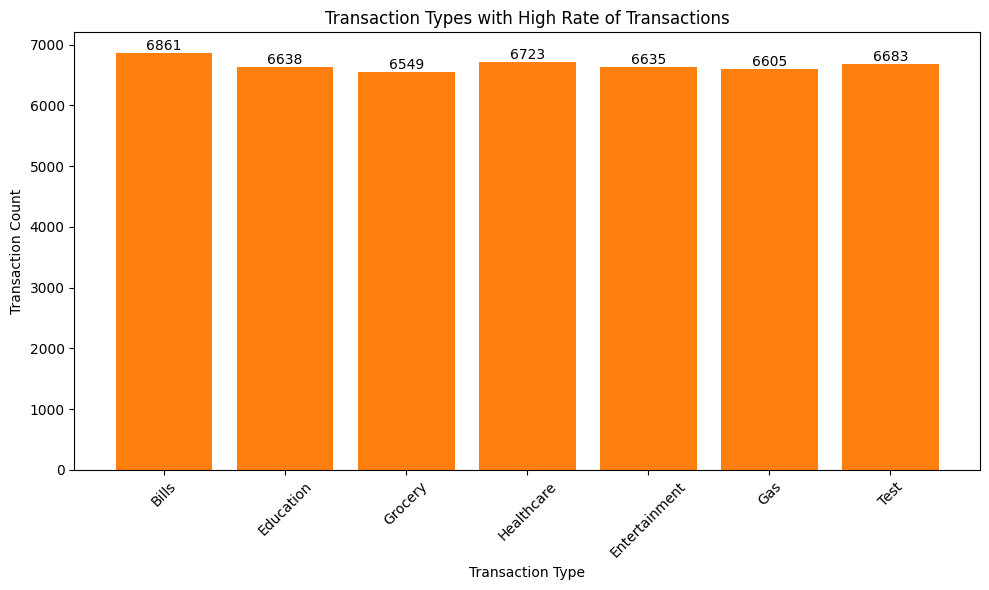

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root',
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)

# Execute a query to get the transaction type counts
query = """
SELECT TRANSACTION_TYPE, COUNT(*) AS transaction_count
FROM creditcard
GROUP BY TRANSACTION_TYPE
"""

# Fetch the results into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Plot the transaction types and their counts
plt.figure(figsize=(10, 6))
bars = plt.bar(df["TRANSACTION_TYPE"], df["transaction_count"])
plt.bar(df["TRANSACTION_TYPE"], df["transaction_count"])
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Count")
plt.title("Transaction Types with High Rate of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()

# Add the total count on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Save the plot as an image
plt.savefig("transaction_types.png")

# Close the database connection
conn.close()


Functional Requirements 3.2

C:\Users\ibadw\AppData\Local\Temp\ipykernel_33196\3932192534.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


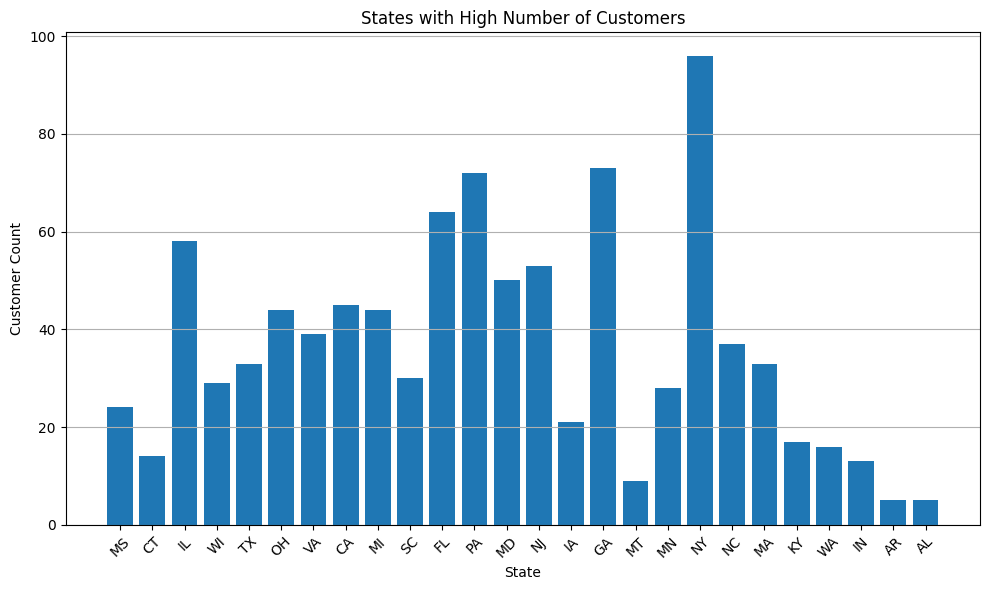

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root',
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)

# Execute a query to get the customer count by state
query = """
SELECT CUST_STATE, COUNT(*) AS customer_count
FROM customer
GROUP BY CUST_STATE
"""

# Fetch the results into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Plot the states and their customer counts
plt.figure(figsize=(10, 6))
plt.bar(df["CUST_STATE"], df["customer_count"])
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("States with High Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()

# Show grid lines on the y-axis
plt.grid(axis='y')

# Save the plot as an image
plt.savefig("states_customer_count.png")

# Close the database connection
conn.close()


Functional Requirements 3.3

C:\Users\ibadw\AppData\Local\Temp\ipykernel_33196\1608473782.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Customer with the highest transaction amount:
CUST_SSN        123451125
total_amount      5633.07
Name: 0, dtype: object


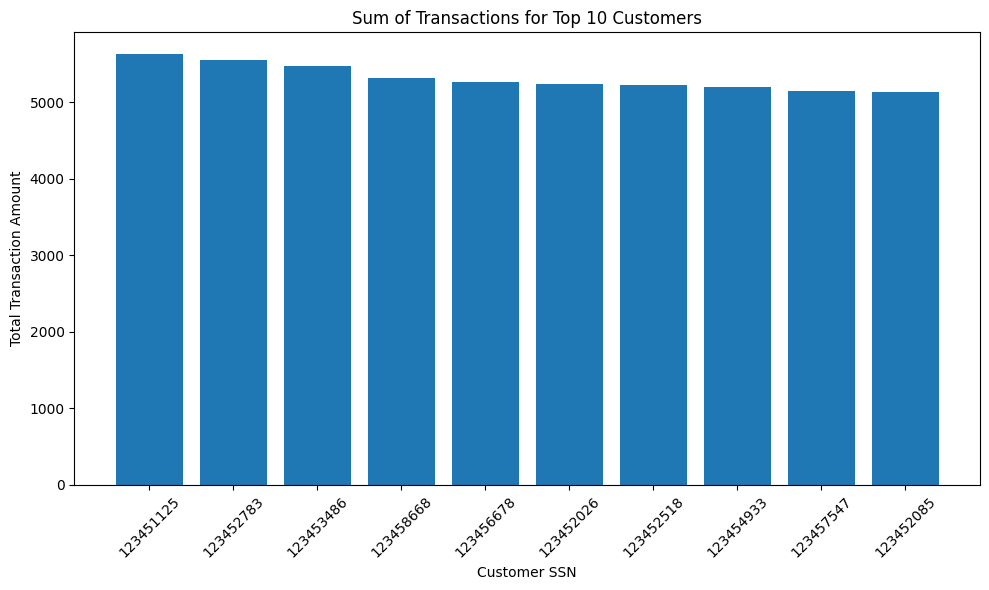

In [114]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root',
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)

# Execute a query to get the sum of transactions for the top 10 customers
query = """
SELECT 
	CAST(CUST_SSN AS char) AS CUST_SSN,
	total_amount
FROM
(
SELECT CUST_SSN, ROUND(SUM(Transaction_Value),2) AS total_amount, RANK() OVER(ORDER BY SUM(Transaction_Value) DESC) as rankid
FROM creditcard
GROUP BY CUST_SSN
ORDER BY total_amount DESC
) nest
WHERE nest.rankid <= 10;
"""

# # Fetch the result into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Plot the sum of transactions for the top 10 customers
plt.figure(figsize=(10, 6))
plt.bar(df['CUST_SSN'], df['total_amount'])
plt.xlabel('Customer SSN')
plt.ylabel('Total Transaction Amount')
plt.title('Sum of Transactions for Top 10 Customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image
plt.savefig('top_10_customers_transactions.png')

# # Get the customer with the highest transaction amount
customer_with_highest_amount = df.loc[df['total_amount'].idxmax()]

# # Print the customer with the highest transaction amount
print("Customer with the highest transaction amount:")
print(customer_with_highest_amount)

# Close the database connection
conn.close()


In [108]:
from pyspark.sql import SparkSession, functions as F
from urllib.request import urlopen

spark = SparkSession.builder.getOrCreate()

url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
jsonData = urlopen(url).read().decode('utf-8')
rdd = spark.sparkContext.parallelize([jsonData])
df = spark.read.json(rdd)
df.describe

query here

df.createOrReplaceGlobalTempView("loan_data")
loan_result_df = spark.sql(query)
print(loan_result_df)

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `CUST_SSN` cannot be resolved. Did you mean one of the following? [`global_temp`.`loan_data`.`Gender`, `global_temp`.`loan_data`.`Income`, `global_temp`.`loan_data`.`Married`, `global_temp`.`loan_data`.`Education`, `global_temp`.`loan_data`.`Dependents`].; line 2 pos 7;
'GlobalLimit 10
+- 'LocalLimit 10
   +- 'Sort ['total_amount DESC NULLS LAST], true
      +- 'Aggregate ['CUST_SSN], ['CUST_SSN, 'SUM('Transaction_Amount) AS total_amount#1022]
         +- SubqueryAlias global_temp.loan_data
            +- View (`global_temp`.`loan_data`, [Application_ID#1002,Application_Status#1003,Credit_History#1004L,Dependents#1005,Education#1006,Gender#1007,Income#1008,Married#1009,Property_Area#1010,Self_Employed#1011])
               +- LogicalRDD [Application_ID#1002, Application_Status#1003, Credit_History#1004L, Dependents#1005, Education#1006, Gender#1007, Income#1008, Married#1009, Property_Area#1010, Self_Employed#1011], false


In [107]:
df.columns

['Application_ID',
 'Application_Status',
 'Credit_History',
 'Dependents',
 'Education',
 'Gender',
 'Income',
 'Married',
 'Property_Area',
 'Self_Employed']